In [2]:
import torch
import math
from PIL import Image, ImageDraw, ImageFont
import logging
import os
def compute_ca_loss(attn_maps_mid, attn_maps_up, bboxes, object_positions):
    loss = 0
    object_number = len(bboxes)
    if object_number == 0:
        return torch.tensor(0).float().cuda() if torch.cuda.is_available() else torch.tensor(0).float()
    for attn_map_integrated in attn_maps_mid:
        attn_map = attn_map_integrated #.chunk(2)[1]

        #
        b, i, j = attn_map.shape
        H = W = int(math.sqrt(i))
        for obj_idx in range(object_number):
            obj_loss = 0
            mask = torch.zeros(size=(H, W)).cuda() if torch.cuda.is_available() else torch.zeros(size=(H, W))
            for obj_box in bboxes[obj_idx]:

                x_min, y_min, x_max, y_max = int(obj_box[0] * W), \
                    int(obj_box[1] * H), int(obj_box[2] * W), int(obj_box[3] * H)
                mask[y_min: y_max, x_min: x_max] = 1

            for obj_position in object_positions[obj_idx]:
                ca_map_obj = attn_map[:, :, obj_position].reshape(b, H, W)

                activation_value = (ca_map_obj * mask).reshape(b, -1).sum(dim=-1)/ca_map_obj.reshape(b, -1).sum(dim=-1)

                obj_loss += torch.mean((1 - activation_value) ** 2)
            loss += (obj_loss/len(object_positions[obj_idx]))

    for attn_map_integrated in attn_maps_up[0]:
        attn_map = attn_map_integrated  #.chunk(2)[1]
        #
        b, i, j = attn_map.shape
        H = W = int(math.sqrt(i))

        for obj_idx in range(object_number):
            obj_loss = 0
            mask = torch.zeros(size=(H, W)).cuda() if torch.cuda.is_available() else torch.zeros(size=(H, W))
            for obj_box in bboxes[obj_idx]:
                x_min, y_min, x_max, y_max = int(obj_box[0] * W), \
                    int(obj_box[1] * H), int(obj_box[2] * W), int(obj_box[3] * H)
                mask[y_min: y_max, x_min: x_max] = 1

            for obj_position in object_positions[obj_idx]:
                ca_map_obj = attn_map[:, :, obj_position].reshape(b, H, W)
                # ca_map_obj = attn_map[:, :, object_positions[obj_position]].reshape(b, H, W)

                activation_value = (ca_map_obj * mask).reshape(b, -1).sum(dim=-1) / ca_map_obj.reshape(b, -1).sum(
                    dim=-1)

                obj_loss += torch.mean((1 - activation_value) ** 2)
            loss += (obj_loss / len(object_positions[obj_idx]))
    loss = loss / (object_number * (len(attn_maps_up[0]) + len(attn_maps_mid)))
    return loss

def Pharse2idx(prompt, phrases):
    phrases = [x.strip() for x in phrases.split(';')]
    prompt_list = prompt.strip('.').split(' ')
    object_positions = []
    for obj in phrases:
        obj_position = []
        for word in obj.split(' '):
            obj_first_index = prompt_list.index(word) + 1
            obj_position.append(obj_first_index)
        object_positions.append(obj_position)

    return object_positions

def draw_box(pil_img, bboxes, phrases, save_path):
    draw = ImageDraw.Draw(pil_img)
    font = ImageFont.truetype('./FreeMono.ttf', 25)
    phrases = [x.strip() for x in phrases.split(';')]
    for obj_bboxes, phrase in zip(bboxes, phrases):
        for obj_bbox in obj_bboxes:
            x_0, y_0, x_1, y_1 = obj_bbox[0], obj_bbox[1], obj_bbox[2], obj_bbox[3]
            draw.rectangle([int(x_0 * 512), int(y_0 * 512), int(x_1 * 512), int(y_1 * 512)], outline='red', width=5)
            draw.text((int(x_0 * 512) + 5, int(y_0 * 512) + 5), phrase, font=font, fill=(255, 0, 0))
    pil_img.save(save_path)



def setup_logger(save_path, logger_name):
    logger = logging.getLogger(logger_name)
    logger.setLevel(logging.INFO)

    # Create a file handler to write logs to a file
    file_handler = logging.FileHandler(os.path.join(save_path, f"{logger_name}.log"))
    file_handler.setLevel(logging.INFO)

    # Create a formatter to format log messages
    formatter = logging.Formatter('%(asctime)s - %(name)s - %(levelname)s - %(message)s')

    # Set the formatter for the file handler
    file_handler.setFormatter(formatter)

    # Add the file handler to the logger
    logger.addHandler(file_handler)

    return logger


In [3]:
import torch
import math
import random
#from omegaconf import OmegaConf
from transformers import CLIPTextModel, CLIPTokenizer
from torchvision import transforms

from diffusers import AutoencoderKL, LMSDiscreteScheduler, PNDMScheduler
from my_model import unet_2d_condition
import json
from PIL import Image, ImageDraw

#import hydra
import os
from tqdm import tqdm
from IPython.display import display


with open('./my_model/my_conf/unet_config.json') as f:
        unet_config = json.load(f)
model_path='runwayml/stable-diffusion-v1-5' 

unet = unet_2d_condition.UNet2DConditionModel(**unet_config).from_pretrained(model_path, subfolder="unet")
tokenizer = CLIPTokenizer.from_pretrained(model_path, subfolder="tokenizer")
text_encoder = CLIPTextModel.from_pretrained(model_path, subfolder="text_encoder")
vae = AutoencoderKL.from_pretrained(model_path, subfolder="vae")

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

unet.to(device)
text_encoder.to(device)
vae.to(device)

AutoencoderKL(
  (encoder): Encoder(
    (conv_in): Conv2d(3, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (down_blocks): ModuleList(
      (0): DownEncoderBlock2D(
        (resnets): ModuleList(
          (0): ResnetBlock2D(
            (norm1): GroupNorm(32, 128, eps=1e-06, affine=True)
            (conv1): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
            (norm2): GroupNorm(32, 128, eps=1e-06, affine=True)
            (dropout): Dropout(p=0.0, inplace=False)
            (conv2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
            (nonlinearity): SiLU()
          )
          (1): ResnetBlock2D(
            (norm1): GroupNorm(32, 128, eps=1e-06, affine=True)
            (conv1): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
            (norm2): GroupNorm(32, 128, eps=1e-06, affine=True)
            (dropout): Dropout(p=0.0, inplace=False)
            (conv2): Conv2d(128, 128, kernel_size=(3,

In [4]:
def binarize(attention):#now attn has size(1, s1, 1)
    def maxmin_norm(x):
        norm = (x - torch.min(x, 1, keepdim=True)[0])/ (torch.max(x, 1, keepdim=True)[0] - torch.min(x, 1, keepdim=True)[0])
        return norm

    s = 10.
    attn_new = maxmin_norm((s * (maxmin_norm(attention) - 0.5)).sigmoid())
    return attn_new

def property_aa(attention_k, activation, device):#activation has shape b, c, h, w
  #centroid
  shape=int(math.sqrt(attention_k.shape[1]))

  ls = torch.linspace(0, 1, steps=shape).to(device) #activation.shape[-1]=innerD
  col = ls.repeat(shape, 1)
  row = col.t()#transpose

  col = torch.stack([col], dim=0).view(1, -1)
  row = torch.stack([row], dim=0).view(1, -1)

  attn_col = (attention_k * col.unsqueeze(-1)).sum(1) / attention_k.sum(1)
  attn_row = (attention_k * row.unsqueeze(-1)).sum(1) / attention_k.sum(1)

  #shape
  attn_shape = binarize(attention_k)#now attention_k has size (b, s1, 1)

  ### size
  attn_size = attn_shape.sum(1) / shape ** 2

  ### appearance
  actv = activation.view(activation.shape[0], activation.shape[1], -1)#batch, channels, H*W
  appr = (actv.unsqueeze(2) * attn_shape.unsqueeze(1).transpose(2,3)).sum(-1) / attn_shape.sum(1).unsqueeze(1) #appr has shape b, c, 1
  #actv.unsqueeze(2)-> b, c, 1, HW
  # attn_shape.unsqueeze(1)-> b, 1, H*W, 1
  # .transpose(2,3)-> b, 1, 1, HW
  #*-> b, c, 1  HW
  #.sum->b, c, 1

  return attn_col, attn_row, attn_shape, attn_size, appr

#stable diffusion w/o any guidance

In [5]:
def encode_text(prompt):

  uncond_input = tokenizer(
          "", padding="max_length", max_length=tokenizer.model_max_length, return_tensors="pt"
      )

  uncond_embeddings = text_encoder(uncond_input.input_ids.to(device))[0]
  input_ids = tokenizer(
          prompt,
          padding="max_length",
          truncation=True,
          max_length=tokenizer.model_max_length,
          return_tensors="pt",
      )

  cond_embeddings = text_encoder(input_ids.input_ids.to(device))[0]
  return cond_embeddings, torch.cat([uncond_embeddings, cond_embeddings])

def target_index(prompt, target):
  for index, i in enumerate(prompt.split()):
    if target==i: return torch.tensor([index+1])

def stablediffusion(text_embeddings, seed=None):

  if seed is None: seed = random.randrange(2**32 - 1)

  generator = torch.manual_seed(seed)
  latents = torch.randn(
          (1, 4, 64, 64),
          generator=generator,
      ).to(device)

  noise_scheduler = LMSDiscreteScheduler(beta_start=0.00085, beta_end=0.012,beta_schedule="scaled_linear", num_train_timesteps=1000)
  noise_scheduler.set_timesteps(51)

  latents = latents * noise_scheduler.init_noise_sigma

  for index, t in enumerate(tqdm(noise_scheduler.timesteps)):
    
    with torch.no_grad():
      latent_model_input = torch.cat([latents] * 2)
      latent_model_input = noise_scheduler.scale_model_input(latent_model_input, t)
      noise_pred, attn_map_integrated_up, attn_map_integrated_mid, attn_map_integrated_down,_,_,_ = \
          unet(latent_model_input, t, encoder_hidden_states=text_embeddings)

      noise_pred = noise_pred.sample

      # perform guidance
      noise_pred_uncond, noise_pred_text = noise_pred.chunk(2)
      noise_pred = noise_pred_uncond + 7.5 * (noise_pred_text - noise_pred_uncond)

      latents = noise_scheduler.step(noise_pred, t, latents).prev_sample
      torch.cuda.empty_cache()
  return latents


def decode_img(latents):
  with torch.no_grad():
    latents = 1 / 0.18215 * latents
    image = vae.decode(latents).sample
    image = (image / 2 + 0.5).clamp(0, 1)
    image = image.detach().cpu().permute(0, 2, 3, 1).numpy()
    images = (image * 255).round().astype("uint8")
    pil_images = [Image.fromarray(image) for image in images]
    display(*pil_images)

In [6]:
#source: prompt, seed-->recreate
#new: prompt, seed(optional), target

def appr_control(ori_seed,
                 ori_prompt,
                 new_prompt,
                 target,
                 new_seed=None):

  #get text embedding
  ori_text_embeddings = encode_text(ori_prompt)[1]

  new_text_embeddings = encode_text(new_prompt)[1]
  new_cond_embeddings = encode_text(new_prompt)[0]

  #get position of target in each prompt
  position_ori=target_index(ori_prompt,target)
  position_new=target_index(new_prompt,target)

  #seperate scheduler should be used for ori and new img
  noise_scheduler_org = LMSDiscreteScheduler(beta_start=0.00085, beta_end=0.012, beta_schedule="scaled_linear", num_train_timesteps=1000)
  noise_scheduler_org.set_timesteps(51)

  generator = torch.manual_seed(ori_seed)
  latents_org = torch.randn(
          (1, 4, 64, 64),
          generator=generator,
      ).to(device)
  latents_org = latents_org * noise_scheduler_org.init_noise_sigma

  noise_scheduler = LMSDiscreteScheduler(beta_start=0.00085, beta_end=0.012, beta_schedule="scaled_linear", num_train_timesteps=1000)
  noise_scheduler.set_timesteps(51)

  if new_seed is None: new_seed = random.randrange(2**32 - 1)
  generator = torch.manual_seed(new_seed)
  latents=torch.randn(
          (1, 4, 64, 64),
          generator=generator,
      ).to(device)
  latents=latents* noise_scheduler.init_noise_sigma

  #update latent for new img


  ####################################################################start iteration
  for index, t in enumerate(tqdm(noise_scheduler.timesteps)):

    ###recreate org image
    with torch.no_grad():
      latent_model_input_org = torch.cat([latents_org] * 2)
      latent_model_input_org = noise_scheduler_org.scale_model_input(latent_model_input_org, t)
      noise_pred_org, attn_map_integrated_up_org, attn_map_integrated_mid_org, attn_map_integrated_down_org, act_up_org, act_mid_org, act_down_org = \
          unet(latent_model_input_org, t, encoder_hidden_states=ori_text_embeddings)

      noise_pred_org = noise_pred_org.sample

      noise_pred_uncond_org, noise_pred_text_org = noise_pred_org.chunk(2)
      noise_pred_org = noise_pred_uncond_org + 7.5 * (noise_pred_text_org - noise_pred_uncond_org)

      latents_org = noise_scheduler_org.step(noise_pred_org, t, latents_org).prev_sample

    torch.cuda.empty_cache()
    ###end recreate ori image
    loss=torch.tensor(10000)
    iter=0
    #####upadate latent for new img
    while loss.item()>0.1 and ((index<11 and iter<5) or (index%5==0 and index<25 and iter<5)): #you can change the threshold
      list_score=[]

      #temperary forward of new img
      latents = latents.requires_grad_(True)

      latent_model_input = latents#tmp
      latent_model_input = noise_scheduler.scale_model_input(latent_model_input,t)

      noise_pred, attn_map_integrated_up, attn_map_integrated_mid, attn_map_integrated_down, act_up, act_mid, act_down= \
        unet(latent_model_input, t, encoder_hidden_states=new_cond_embeddings)


      ###obtain list of attention layers
      list_aa_org=[]
      list_act_org=[]

      for block1, block2 in zip(attn_map_integrated_down_org, act_down_org):
        for trans1, trans2 in zip(block1, block2):
          list_aa_org.append(trans1.chunk(2)[1])
          list_act_org.append(trans2.chunk(2)[1])

      for trans1, trans2 in zip(attn_map_integrated_mid_org, act_mid_org):
        list_aa_org.append(trans1.chunk(2)[1])
        list_act_org.append(trans2.chunk(2)[1])

      for block1, block2 in zip(attn_map_integrated_up_org, act_up_org):
        for trans1, trans2 in zip(block1, block2):
          list_aa_org.append(trans1.chunk(2)[1])
          list_act_org.append(trans2.chunk(2)[1])

      #obtain list_aa
      list_aa=[]
      list_act=[]

      for block1, block2 in zip(attn_map_integrated_down, act_down):
        for trans1, trans2 in zip(block1, block2):
          list_aa.append(trans1)
          list_act.append(trans2)

      for trans1, trans2 in zip(attn_map_integrated_mid, act_mid):
        list_aa.append(trans1)
        list_act.append(trans2)

      for block1, block2 in zip(attn_map_integrated_up, act_up):
        for trans1, trans2 in zip(block1, block2):
          list_aa.append(trans1)
          list_act.append(trans2)

      ###now list_aa contain attn-map elements


      w1=10. #for weight of appr (if there are other prop)
      v=10. #for adjusting grad size


      ###extract object's attn slice of each map
      for idx, (aa, act) in enumerate(zip(list_aa, list_act)):
        aa_org=list_aa_org[idx]
        act_org=list_act_org[idx]

        attention_k1 = aa[:,:,position_new].mean(-1, keepdim=True) #sweater

        attention_k1_org=aa_org[:,:,position_ori].mean(-1, keepdim=True)

        #score_centroid = 2.0 * (torch.abs(aa_col -0.9).mean(-1) + torch.abs(aa_row - 0.2).mean(-1)) / 2.
        #score_shape=10*torch.abs(aa_shape-aa_shape_org).mean(-2).mean(-1)

        if idx not in [2,4,5,6,7,8]:
        #if idx not in [50]:
          aa_col1, aa_row1, aa_shape1, aa_size1, aa_appr1 =property_aa(attention_k1, act, device=device) #extract prop for k1

          aa_col_org, aa_row_org, aa_shape_org, aa_size_org, aa_appr_org =property_aa(attention_k1_org, act_org, device=device)

          score_appr= w1 * torch.abs(aa_appr1 - aa_appr_org).mean(-2).mean(-1)
          list_score.append(score_appr)#score in all maps
      ###end extraction object's feature


      #update latent by gradient decent
      loss = torch.mean(torch.stack(list_score, dim=0), dim=0)[0]
      grad_cond = torch.autograd.grad(loss.requires_grad_(True), [latents])[0]
      #grad_cond=0


      latents = latents -v*grad_cond * noise_scheduler.sigmas[index] #update new_latent according to the guidance
      torch.cuda.empty_cache()
      iter+=1

      print(f'iteration {iter}, loss={loss.item()}')
  ######end update latent for new img

    with torch.no_grad(): #for new img
      latent_model_input = torch.cat([latents] * 2)
      latent_model_input = noise_scheduler.scale_model_input(latent_model_input, t)
      noise_pred, attn_map_integrated_up, attn_map_integrated_mid, attn_map_integrated_down, _, _, _ = \
          unet(latent_model_input, t, encoder_hidden_states=new_text_embeddings)

      noise_pred = noise_pred.sample

      # perform guidance
      noise_pred_uncond, noise_pred_text = noise_pred.chunk(2)
      noise_pred = noise_pred_uncond + 7.5 * (noise_pred_text - noise_pred_uncond)

      latents = noise_scheduler.step(noise_pred, t, latents).prev_sample
      torch.cuda.empty_cache()
  return latents


100%|██████████| 51/51 [14:08<00:00, 16.64s/it]


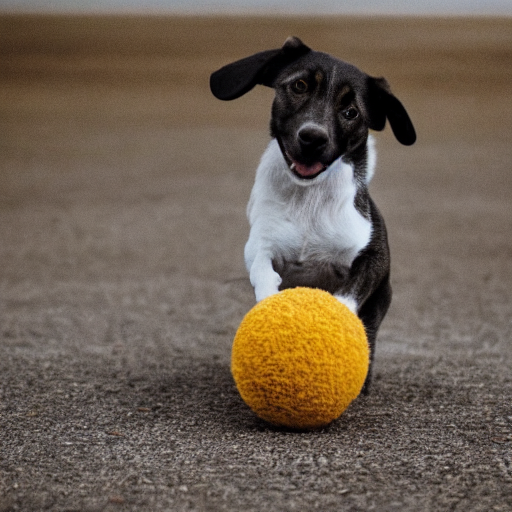

In [7]:
prompt="a photo of a cute dog playing with a ball"
decode_img(stablediffusion(encode_text(prompt)[1], seed=15))

  0%|          | 0/51 [00:00<?, ?it/s]

iteration 1, loss=2.8928303718566895
iteration 2, loss=2.7480626106262207
iteration 3, loss=2.6221299171447754
iteration 4, loss=2.538635730743408
iteration 5, loss=2.471867084503174


  2%|▏         | 1/51 [01:50<1:31:52, 110.26s/it]

iteration 1, loss=2.690840721130371
iteration 2, loss=2.6087098121643066
iteration 3, loss=2.535414457321167
iteration 4, loss=2.4655601978302
iteration 5, loss=2.4016101360321045


  4%|▍         | 2/51 [03:41<1:30:36, 110.96s/it]

iteration 1, loss=2.6441547870635986
iteration 2, loss=2.5506749153137207
iteration 3, loss=2.4711291790008545
iteration 4, loss=2.3954505920410156
iteration 5, loss=2.254589557647705


  6%|▌         | 3/51 [05:31<1:28:10, 110.21s/it]

iteration 1, loss=2.5659313201904297
iteration 2, loss=2.3801496028900146
iteration 3, loss=2.3107423782348633
iteration 4, loss=2.2655060291290283
iteration 5, loss=2.20454478263855


  8%|▊         | 4/51 [07:18<1:25:35, 109.27s/it]

iteration 1, loss=2.5799002647399902
iteration 2, loss=2.3907113075256348
iteration 3, loss=2.337576389312744
iteration 4, loss=2.2622992992401123
iteration 5, loss=2.215388774871826


 10%|▉         | 5/51 [09:09<1:24:04, 109.66s/it]

iteration 1, loss=2.5219357013702393
iteration 2, loss=2.378828287124634
iteration 3, loss=2.3218140602111816
iteration 4, loss=2.295314311981201
iteration 5, loss=2.2406468391418457


 12%|█▏        | 6/51 [11:00<1:22:33, 110.08s/it]

iteration 1, loss=2.544651508331299
iteration 2, loss=2.3726706504821777
iteration 3, loss=2.3152241706848145
iteration 4, loss=2.253455400466919
iteration 5, loss=2.2026658058166504


 14%|█▎        | 7/51 [12:50<1:20:45, 110.12s/it]

iteration 1, loss=2.63586163520813
iteration 2, loss=2.488365888595581
iteration 3, loss=2.490377426147461
iteration 4, loss=2.583056926727295
iteration 5, loss=2.5424697399139404


 16%|█▌        | 8/51 [14:40<1:18:52, 110.06s/it]

iteration 1, loss=3.605816602706909
iteration 2, loss=3.4782943725585938
iteration 3, loss=3.3060994148254395
iteration 4, loss=3.1741783618927
iteration 5, loss=3.0429463386535645


 18%|█▊        | 9/51 [16:28<1:16:41, 109.57s/it]

iteration 1, loss=3.5148608684539795
iteration 2, loss=3.312877655029297
iteration 3, loss=3.230839252471924
iteration 4, loss=3.1755123138427734
iteration 5, loss=3.090381622314453


 20%|█▉        | 10/51 [18:17<1:14:38, 109.23s/it]

iteration 1, loss=3.9097511768341064
iteration 2, loss=3.8070645332336426
iteration 3, loss=3.7491660118103027
iteration 4, loss=3.6949963569641113
iteration 5, loss=3.8054816722869873


 29%|██▉       | 15/51 [21:57<28:19, 47.21s/it]   

iteration 1, loss=4.789405822753906
iteration 2, loss=4.63027286529541
iteration 3, loss=4.609402179718018
iteration 4, loss=4.419035911560059
iteration 5, loss=4.2700910568237305


 39%|███▉      | 20/51 [25:39<19:10, 37.12s/it]

iteration 1, loss=4.634063720703125
iteration 2, loss=4.392593860626221
iteration 3, loss=4.344336032867432
iteration 4, loss=4.0389533042907715
iteration 5, loss=3.9351425170898438


100%|██████████| 51/51 [41:29<00:00, 48.82s/it]


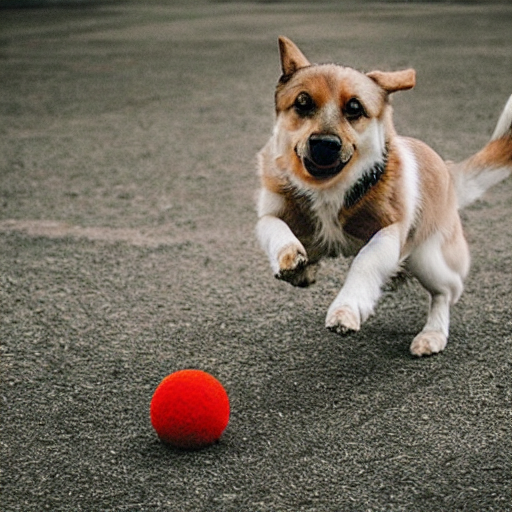

In [8]:
ori_seed=15
ori_prompt="a photo of a cute dog playing with a ball"
new_prompt=ori_prompt
target='ball'
new_seed=None

decode_img(appr_control(ori_seed=ori_seed, ori_prompt=ori_prompt,
                 new_prompt=new_prompt,
                 target=target,
                 new_seed=new_seed))